In [ ]:
# Creating virtual environment
#%pip install virtualenv
#%python3 -m venv env
#%source env/bin/activate

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import sys
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer 
import statsmodels.api as sm 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [5]:
# reading data
data = pd.read_csv("../input/NBA_Dataset.csv")

In [6]:
# view first 3 observations
data.head(3)

,Team,Points_Scored,Weightlifting_Sessions_Average,Yoga_Sessions_Average,Laps_Run_Per_Practice_Average,Water_Intake,Players_Absent_For_Sessions
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0


In [7]:
# shape of the data
data.shape

(159, 7)

In [8]:
# columns in the data
data.columns

Index(['Team', 'Points_Scored', 'Weightlifting_Sessions_Average',
       'Yoga_Sessions_Average', 'Laps_Run_Per_Practice_Average',
       'Water_Intake', 'Players_Absent_For_Sessions'],
      dtype='object')

**Exploratory Data Analysis**

In [9]:
# info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Team                            159 non-null    object 
 1   Points_Scored                   159 non-null    int64  
 2   Weightlifting_Sessions_Average  150 non-null    float64
 3   Yoga_Sessions_Average           139 non-null    float64
 4   Laps_Run_Per_Practice_Average   145 non-null    float64
 5   Water_Intake                    145 non-null    float64
 6   Players_Absent_For_Sessions     130 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.8+ KB


There are total 159 rows and 7 columns. Observe that there are few null values in the dataset

In [11]:
# rename the columns
df = data.rename(columns={'Points_Scored': 'Points', 'Weightlifting_Sessions_Average': 'WL', 'Yoga_Sessions_Average': 'Yoga', 'Laps_Run_Per_Practice_Average': 'Laps', 'Water_Intake': 'WI', 'Players_Absent_For_Sessions': 'PAFS'})

In [12]:
# view first 5 rows
df.head()

,Team,Points,WL,Yoga,Laps,WI,PAFS
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0


Text(0.5, 1.0, 'Distribution plot for Points')

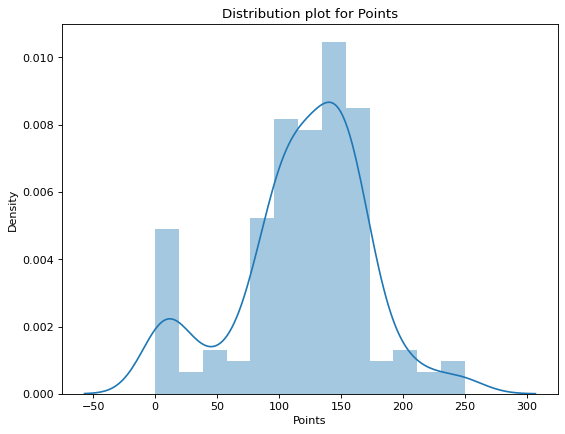

In [13]:
# distribution of Points
figure(figsize=(8,6), dpi=80)
ax = sns.distplot(df.Points)
plt.xlabel("Points")
plt.ylabel("Density")
plt.title("Distribution plot for Points")

Text(0.5, 1.0, 'Distribution plot for Square Root of Points')

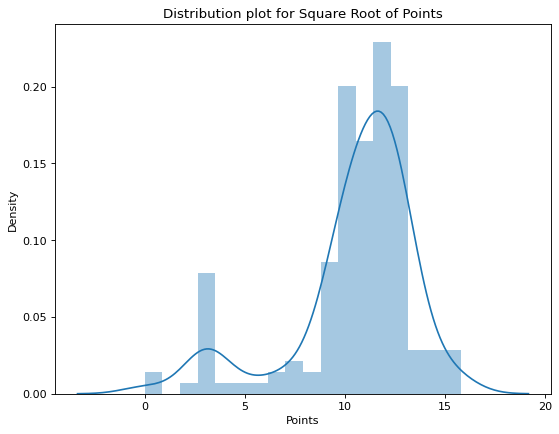

In [15]:
# The data shows some outliers. let's transform it and check
# distribution of Points
figure(figsize=(8,6), dpi=80)
ax = sns.distplot(np.sqrt(df.Points))
plt.xlabel("Points")
plt.ylabel("Density")
plt.title("Distribution plot for Square Root of Points")

Text(0.5, 1.0, 'Box Plot for Points')

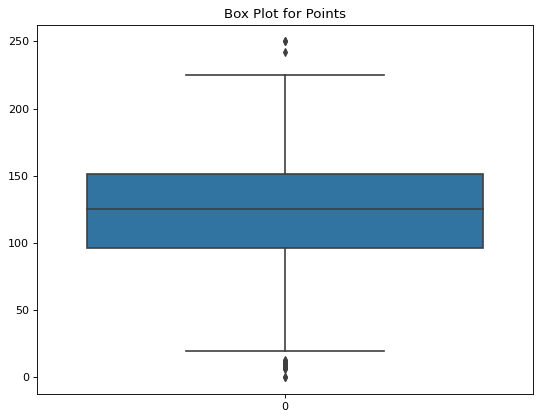

In [16]:
# Lets check the boxplot visualization of Points which tells us the outliers
figure(figsize=(8,6), dpi= 80)
sns.boxplot(df.Points)
plt.title("Box Plot for Points")

In [17]:
df.tail(100)

,Team,Points,WL,Yoga,Laps,WI,PAFS
59,Clippers,156,34.0,28.0,40.0,5.0,5.0
60,Clippers,122,37.0,29.0,44.0,5.0,2.0
61,Warriors,55,14.0,8.0,17.0,3.0,3.0
62,Warriors,60,14.0,8.0,17.0,3.0,4.0
63,Warriors,90,16.0,11.0,20.0,3.0,7.0
...,...,...,...,...,...,...,...
154,Bulls,12,12.0,12.0,13.0,1.0,NaN
155,Bulls,13,12.0,12.0,14.0,1.0,NaN
156,Bulls,12,12.0,13.0,14.0,1.0,NaN
157,Bulls,20,13.0,14.0,15.0,1.0,6.0


In [18]:
# function for plotting violin plots to visualize the distribution and shape of the data
def plotting_box_violin_plots(df, x, y):
    fig, axes= plt.subplots(1,2, figsize=(18,10))
    fig.suptitle("Violin and box-plots for variable: {}".format(y))

    sns.violinplot(ax=axes[0], x=x, y=y, data=df)
    sns.boxplot(ax=axes[1], data=df[y])

    axes[0].set_title("Violin plot for variable: {}".format(y))
    axes[1].set_title("Box plot for variable: {}".format(y))




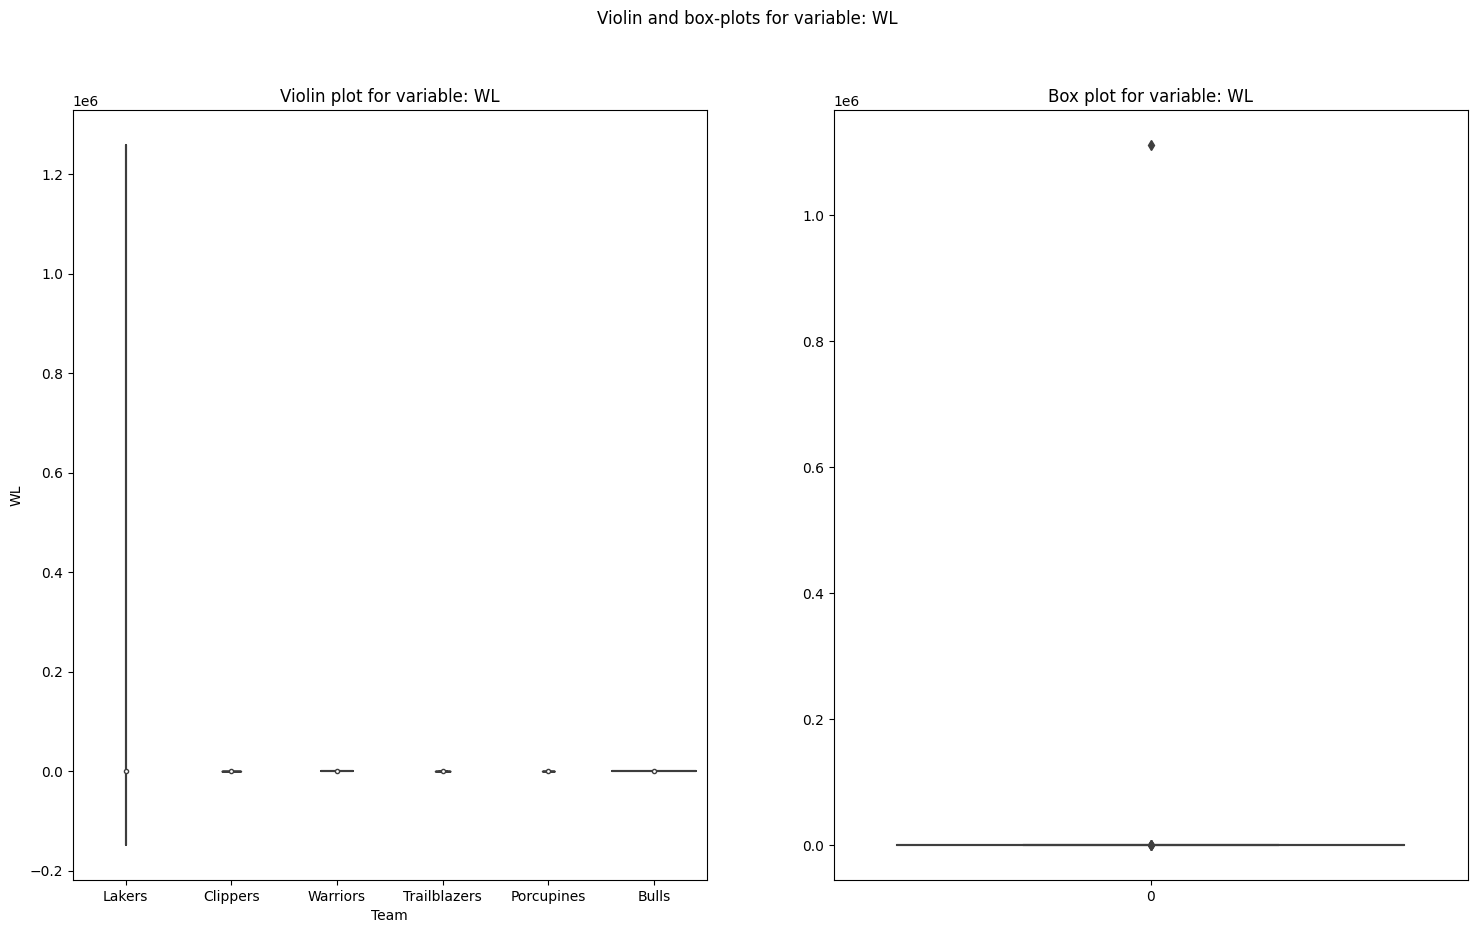

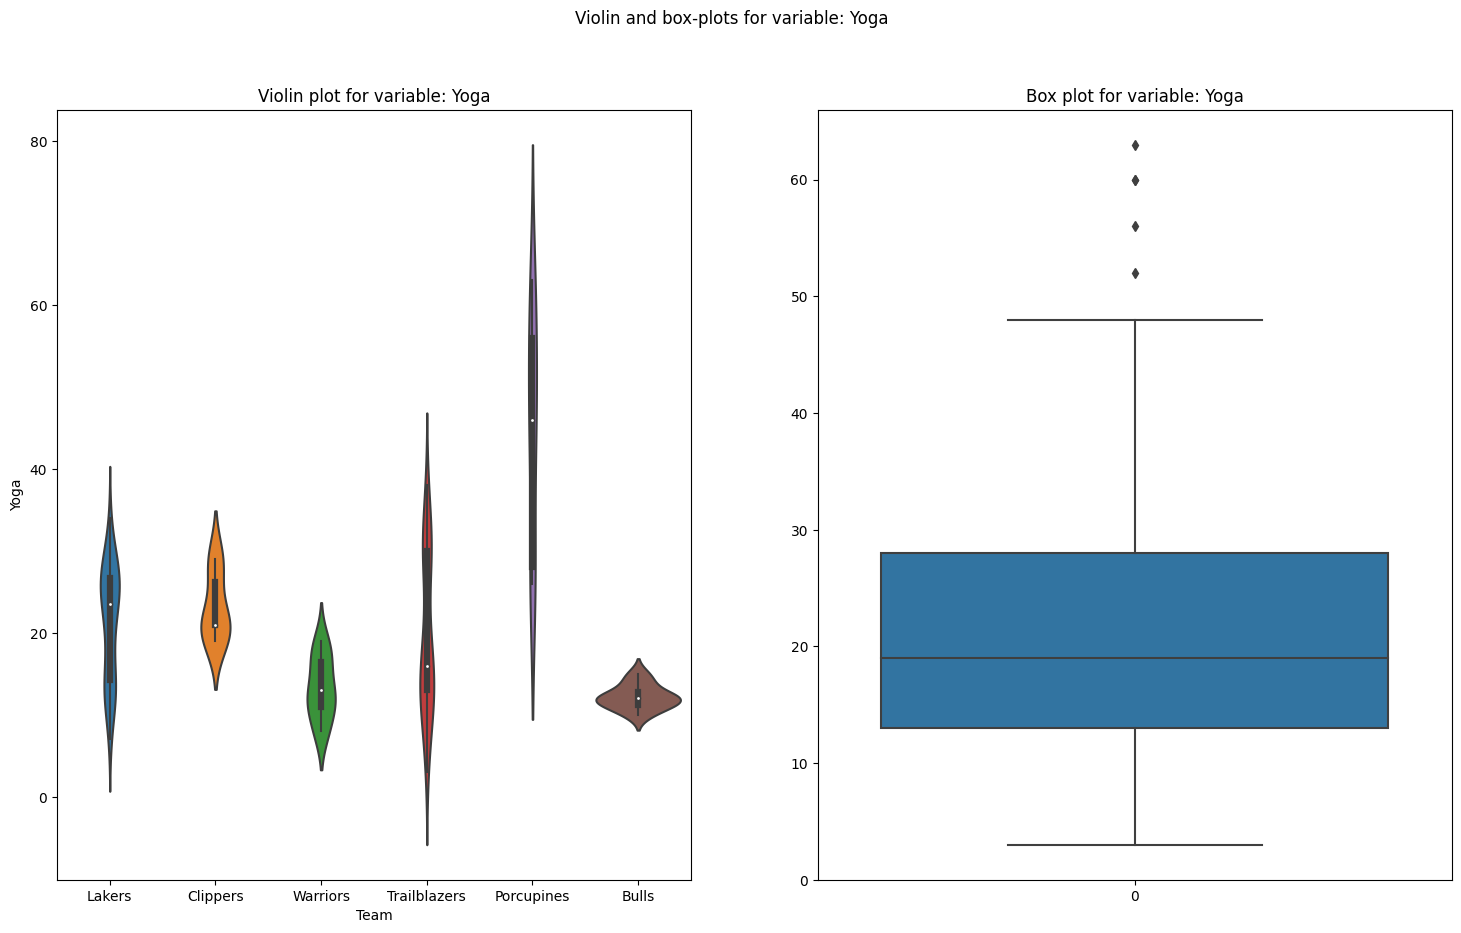

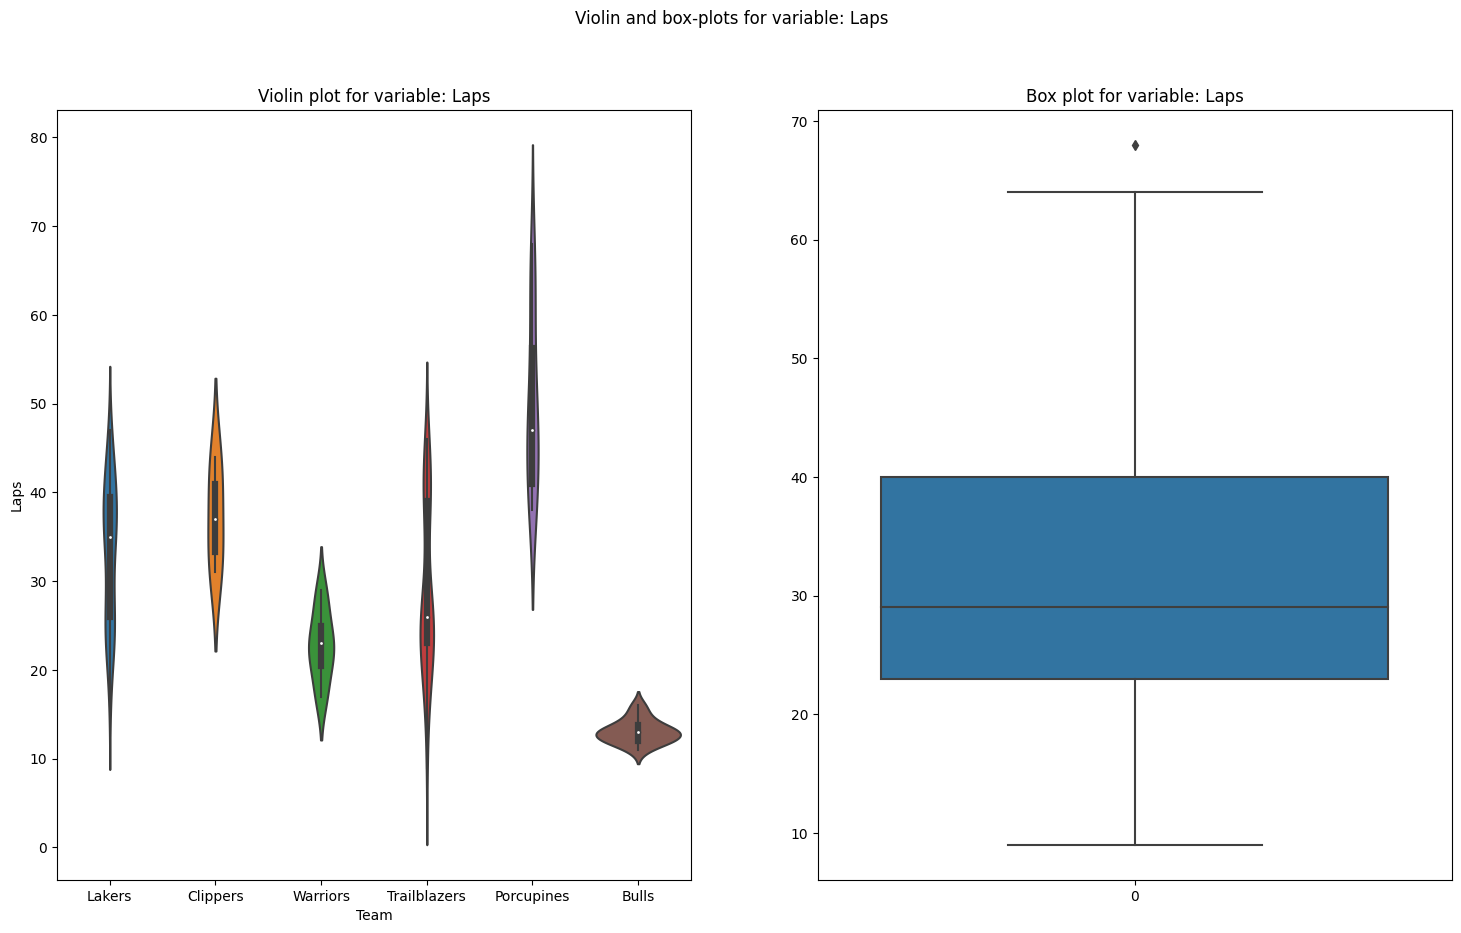

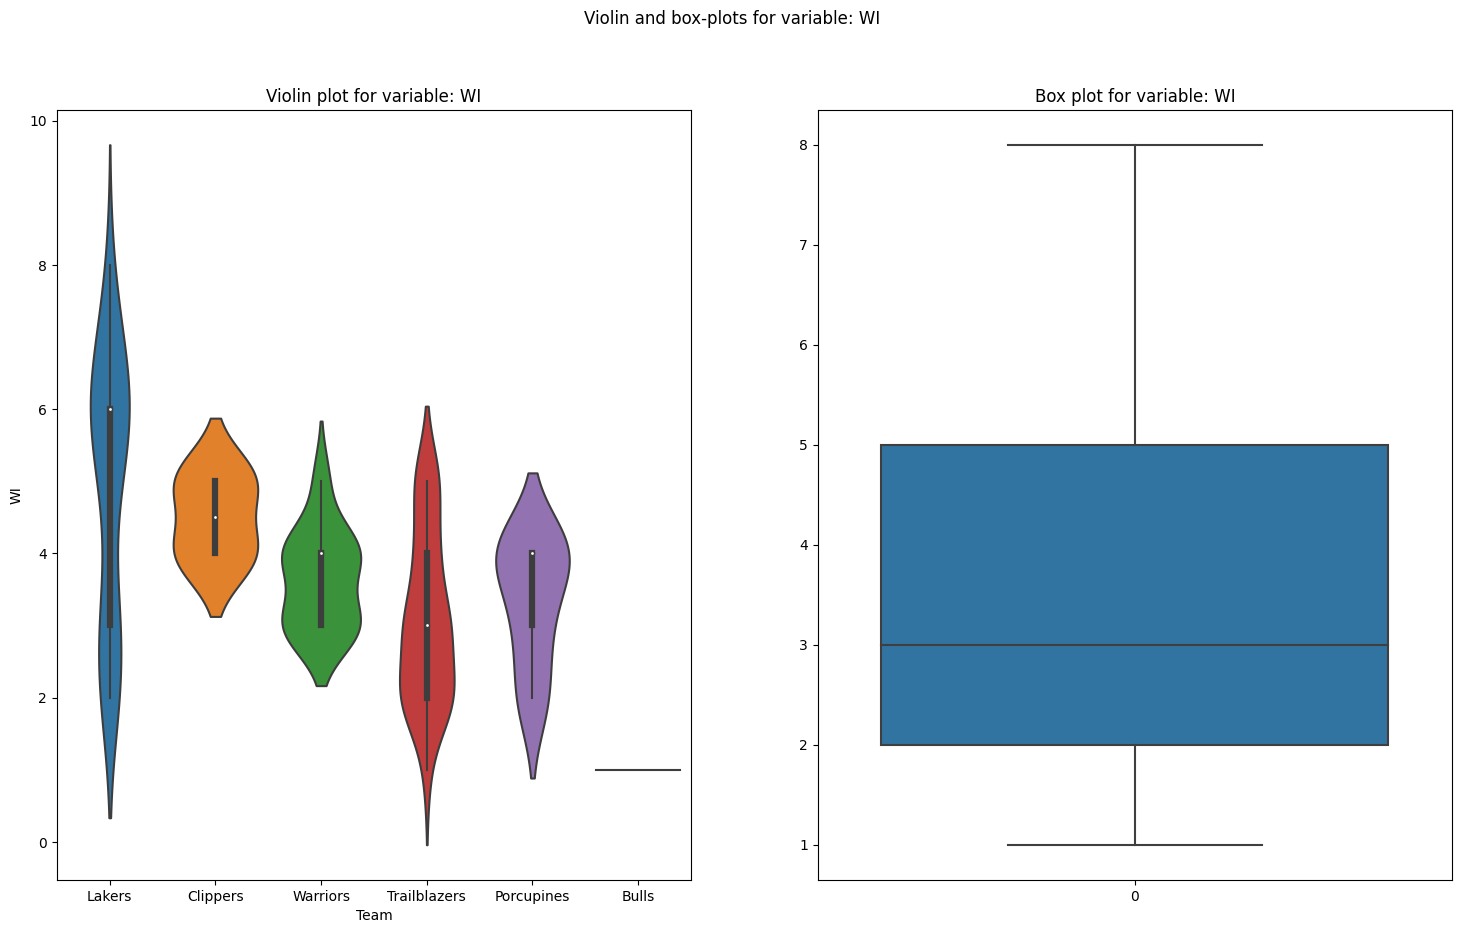

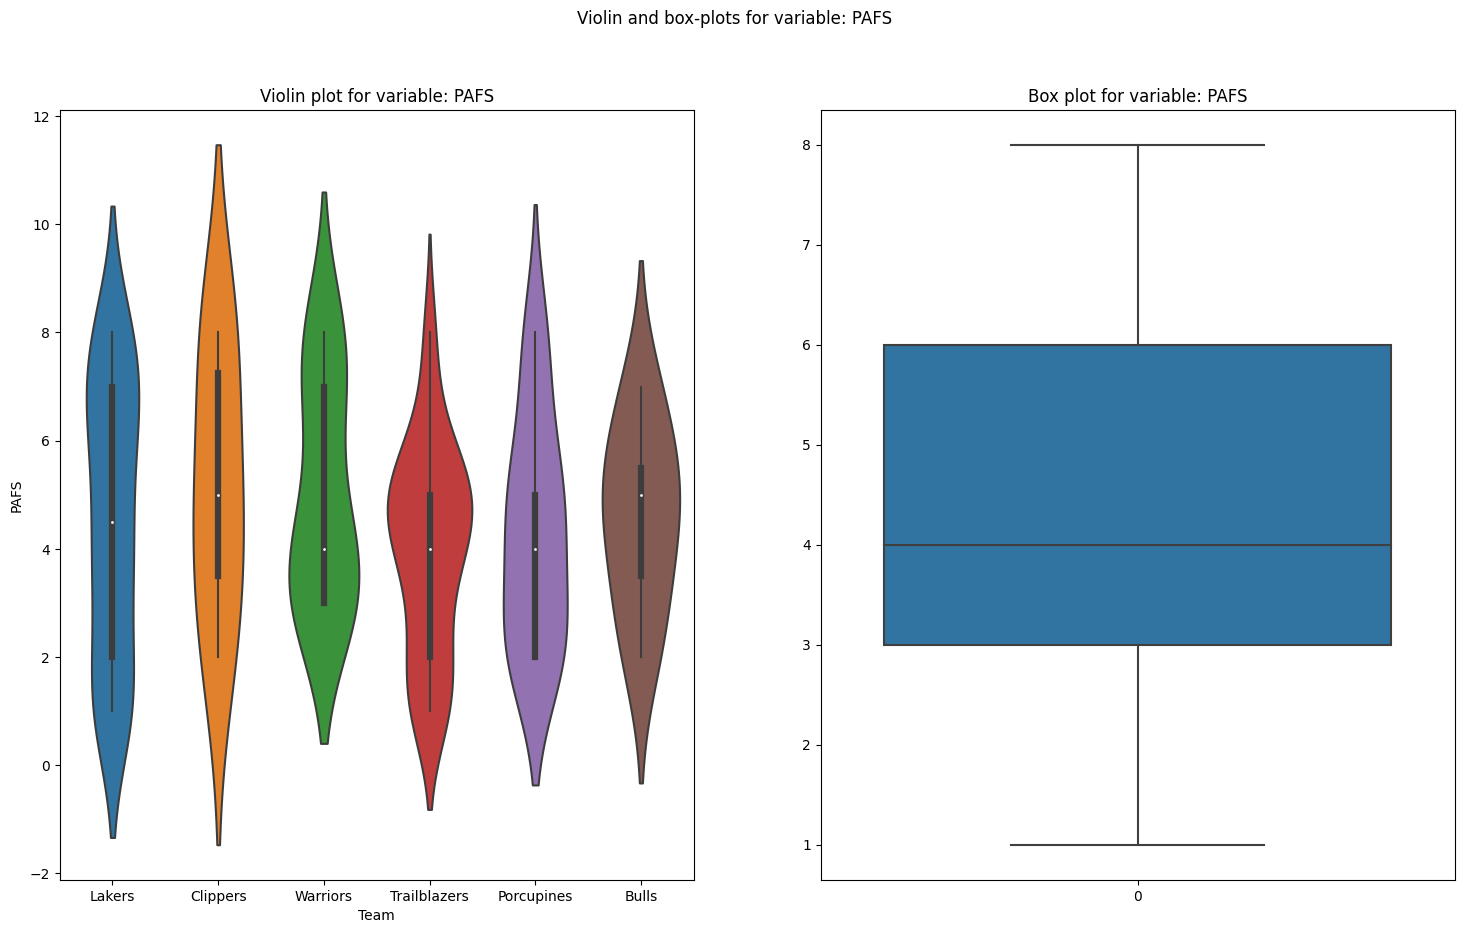

In [19]:
for x in ['WL','Yoga','Laps','WI','PAFS']:
  plotting_box_violin_plots(df,"Team",x)

**Finding Outliers using Inter Quartile Range**     
IQR is calculated as the difference between the 75th and 25th percentiles of the data, and outliers are considered to be any observations that fall below Q1-1.5(IQR) or above Q3+1.5(IQR). This method is based on the assumption that the data is approximately normally distributed